<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Keys" data-toc-modified-id="Keys-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Keys</a></span></li><li><span><a href="#CC-2344:-DEGs-with-similar-expression-levels" data-toc-modified-id="CC-2344:-DEGs-with-similar-expression-levels-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>CC-2344: DEGs with similar expression levels</a></span></li><li><span><a href="#CC-2931:-DEGs-with-similar-expression-levels" data-toc-modified-id="CC-2931:-DEGs-with-similar-expression-levels-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>CC-2931: DEGs with similar expression levels</a></span></li><li><span><a href="#Changing-v6-differentially-expressed-genes-(DEGs)-to-v5" data-toc-modified-id="Changing-v6-differentially-expressed-genes-(DEGs)-to-v5-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Changing v6 differentially expressed genes (DEGs) to v5</a></span></li><li><span><a href="#Null-Hypothesis---Creating-simulated-genes" data-toc-modified-id="Null-Hypothesis---Creating-simulated-genes-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Null Hypothesis - Creating simulated genes</a></span></li><li><span><a href="#Strenkert-PNAS-Coexpression-Network" data-toc-modified-id="Strenkert-PNAS-Coexpression-Network-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Strenkert PNAS Coexpression Network</a></span><ul class="toc-item"><li><span><a href="#Importing-NetworkX-Code" data-toc-modified-id="Importing-NetworkX-Code-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Importing NetworkX Code</a></span></li><li><span><a href="#NetworkX---Multi-source-function-was-amended" data-toc-modified-id="NetworkX---Multi-source-function-was-amended-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>NetworkX - Multi-source function was amended</a></span></li><li><span><a href="#Adding-distance-to-Strenkert-Co-expression-Network" data-toc-modified-id="Adding-distance-to-Strenkert-Co-expression-Network-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Adding distance to Strenkert Co-expression Network</a></span></li><li><span><a href="#Finding-the-shortest-path-between-observed-DEGs" data-toc-modified-id="Finding-the-shortest-path-between-observed-DEGs-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Finding the shortest path between observed DEGs</a></span></li><li><span><a href="#Null-Hypothesis---scripts/snakefile_networkx_shortest_paths.py" data-toc-modified-id="Null-Hypothesis---scripts/snakefile_networkx_shortest_paths.py-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Null Hypothesis - scripts/snakefile_networkx_shortest_paths.py</a></span></li><li><span><a href="#Plots---Shortest-Paths-between-DEGs-in-Co-expression-Network" data-toc-modified-id="Plots---Shortest-Paths-between-DEGs-in-Co-expression-Network-6.6"><span class="toc-item-num">6.6&nbsp;&nbsp;</span>Plots - Shortest Paths between DEGs in Co-expression Network</a></span><ul class="toc-item"><li><span><a href="#Observed-vs-Null-Distributions" data-toc-modified-id="Observed-vs-Null-Distributions-6.6.1"><span class="toc-item-num">6.6.1&nbsp;&nbsp;</span>Observed vs Null Distributions</a></span></li><li><span><a href="#Representative-Plot-(CC-2344-L1)---Observed-vs-Null-Distributions" data-toc-modified-id="Representative-Plot-(CC-2344-L1)---Observed-vs-Null-Distributions-6.6.2"><span class="toc-item-num">6.6.2&nbsp;&nbsp;</span>Representative Plot (CC-2344 L1) - Observed vs Null Distributions</a></span></li><li><span><a href="#Permutations-test---Shortest-distance-of-observed-vs-simulated-degs-over-varying-distances" data-toc-modified-id="Permutations-test---Shortest-distance-of-observed-vs-simulated-degs-over-varying-distances-6.6.3"><span class="toc-item-num">6.6.3&nbsp;&nbsp;</span>Permutations test - Shortest distance of observed vs simulated degs over varying distances</a></span></li></ul></li></ul></li></ul></div>

## Keys

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from Bio import SeqIO
import random, glob
import json
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import chisquare
stats.junk = lambda chisq, df: stats.chi2.sf(chisq, df)
import csv
import gffpandas.gffpandas as gffpd
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statistics import mean
import os

CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]

#### DATAFRAME RECORDING THE GENERATION TIME PER SAMPLE ####
dic_gen = {}
generation = pd.read_csv('/research/projects/chlamydomonas/MAexpression/genome_info/mutation_info/Mutation_Fitness.txt', delimiter = '\t')
generation['Sample'] = generation['Sample'].str.replace('_', '-L')
generation = generation.loc[generation['Sample'].isin(CC2344 + CC2931)]

for i in generation.index.values:
    dic_gen[generation.at[i,'Sample']] = generation.at[i, 'Generation']
    
generations = pd.Series(dic_gen)

#### MUTATIONS ####
mutations = pd.read_csv('/research/projects/chlamydomonas/MAexpression/genome_info/mutation_info/all_mutations.csv', delimiter = '\t')
dic_mut = {maline:mutations.loc[mutations['sample'] == maline].count()[0] for maline in mutations['sample'].values.tolist()}

## CC-2344: DEGs with similar expression levels

In [51]:
raw_count = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2344_deseq_filtered_normalized.txt', delimiter = '\t', index_col = 'Unnamed: 0')[['CC2344-ANC-rep1', 'CC2344-ANC-rep2', 'CC2344-ANC-rep3']]
raw_count['CC2344-ANC'] = raw_count.mean(axis = 1)
conversion = pd.read_csv('/research/projects/chlamydomonas/MAexpression/genome_info/v5.3_to_v5.6_to_v6.csv', delimiter = '\t')

DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes1.csv', delimiter = ',').reset_index()
DEGs = pd.melt(DEGs, id_vars = ['index'], value_vars = CC2344).dropna()
DEGs.columns = ['index', 'sample', 'v6']


#### Creating interval ####
ei = pd.DataFrame()
expression_intervals = []
for perc in range(3, 99, 5):
    expression_intervals.append(np.percentile(raw_count['CC2344-ANC'], perc, axis=0))
    
high_expression = raw_count.loc[raw_count['CC2344-ANC'] > expression_intervals[-1]]
for perc in range(12, 101, 1):
    expression_intervals.append(np.percentile(high_expression, perc))

ei['expression_intervals'] = expression_intervals


for trials in range(0, 100):
    for sample in DEGs['sample'].unique():
        list_of_degs = list(DEGs.loc[DEGs['sample'] == sample]['v6'])
        sim_degs = []
        for degs in list_of_degs:
            deg_count = raw_count.at[degs, 'CC2344-ANC']
            if deg_count == 0:
                minimum = 0
            else: 
                minimum = ei.loc[ei['expression_intervals'] < deg_count].max()[0]
            maximum = ei.loc[ei['expression_intervals'] > deg_count].min()[0]
            a = raw_count.loc[(raw_count['CC2344-ANC'] > minimum) & (raw_count['CC2344-ANC'] < maximum)]
            v5 = np.array(conversion.loc[conversion['v6'].isin(a.index.values)]['v5.5_gene'])
            sim_degs += random.choices(v5, k = 1)
        np.savetxt('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/simulated_DEGs/similar_expression_levels/' + str(trials + 1) + '_' + sample + '.txt', sim_degs, delimiter=',', fmt = '%s')    

8536.613777530089
8165.136076624418
8699.148500610278
8993.988920146021
9286.080570831087
9477.547024833924
9705.266838837248
9887.9915189818
10077.137185849722
10287.0993567033
10400.61398518069
10561.83716269186
10675.983632632993
10868.227051523545
11191.423902694625
11433.889944732993
11611.276355070962
11868.430069088081
12082.752686043465
12314.69826062715
12554.129195990576
12739.885436264218
12967.411621627356
13202.356077013
13468.829628344198
13768.880777269273
13957.366731138534
14254.02660969885
14557.41676865829
14834.730326490671
15007.437837429075
15388.521091979586
15564.931530575139
15770.03593784236
16111.624239527326
16442.21255910822
16879.431684400777
17252.9449278602
17769.019014088834
18356.2013180546
18691.92451296041
19217.48958691474
19635.996243353613
19957.565516108592
20524.57009505698
21275.45909527424
21902.279288624748
22641.440614714476
23901.82274032405
24959.2364786069
25942.698888078507
26961.657787266187
28369.325187327642
29156.70336990931
29832.26

KeyboardInterrupt: 

## CC-2931: DEGs with similar expression levels

In [52]:
raw_count = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2931_deseq_filtered_normalized.txt', delimiter = '\t', index_col = 'Unnamed: 0')[['CC2931-ANC-rep1', 'CC2931-ANC-rep2', 'CC2931-ANC-rep3']]
raw_count['CC2931-ANC'] = raw_count.mean(axis = 1)
conversion = pd.read_csv('/research/projects/chlamydomonas/MAexpression/genome_info/v5.3_to_v5.6_to_v6.csv', delimiter = '\t')

DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes1.csv', delimiter = ',').reset_index()
DEGs = pd.melt(DEGs, id_vars = ['index'], value_vars = CC2931).dropna()
DEGs.columns = ['index', 'sample', 'v6']


#### Creating interval ####
ei = pd.DataFrame()
expression_intervals = []
for perc in range(3, 99, 5):
    expression_intervals.append(np.percentile(raw_count['CC2931-ANC'], perc, axis=0))
    
high_expression = raw_count.loc[raw_count['CC2931-ANC'] > expression_intervals[-1]]
for perc in range(12, 101, 1):
    expression_intervals.append(np.percentile(high_expression, perc))

ei['expression_intervals'] = expression_intervals


for trials in range(0, 100):
    for sample in DEGs['sample'].unique():
        list_of_degs = list(DEGs.loc[DEGs['sample'] == sample]['v6'])
        sim_degs = []
        for degs in list_of_degs:
            deg_count = raw_count.at[degs, 'CC2931-ANC']
            if deg_count == 0:
                minimum = 0
            else: 
                minimum = ei.loc[ei['expression_intervals'] < deg_count].max()[0]
            maximum = ei.loc[ei['expression_intervals'] > deg_count].min()[0]
            a = raw_count.loc[(raw_count['CC2931-ANC'] > minimum) & (raw_count['CC2931-ANC'] < maximum)]
            v5 = np.array(conversion.loc[conversion['v6'].isin(a.index.values)]['v5.5_gene'])
            sim_degs += random.choices(v5, k = 1)
        np.savetxt('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/simulated_DEGs/similar_expression_levels/' + str(trials + 1) + '_' + sample + '.txt', sim_degs, delimiter=',', fmt = '%s')    

6977.325979364819
7185.873188276042
7373.390691249428
7514.806536879876
7695.858236692065
7819.184725524824
7922.856408566773
8091.058523913195
8289.436904038257
8394.551388417349
8537.073616823303
8728.410485155056
8919.983366896407
9059.866211189683
9204.99304299472
9430.309680751288
9583.91718866053
9796.053922050482
9929.801484742453
10119.125289051488
10337.49774977403
10514.598739125999
10702.257081678415
10961.935998758365
11179.480409159883
11292.559811756471
11507.17205611425
11724.221606932613
11921.776866662325
12209.194923531879
12420.646539875
12649.25186719617
12985.398316251185
13312.046925448067
13671.149111376008
14112.022207897355
14432.977336162645
14765.000622574475
15208.658870920253
15725.1221832805
16098.75594197733
16589.848805544283
17361.010345352177
17675.622649658235
18245.51579136557
18579.545348912707
19174.05979266267
20171.99545111836
20663.287466779526
21074.052908837395
22258.61263129316
22634.412035252768
23308.10109881982
24223.21319373194
25448.6790

## Changing v6 differentially expressed genes (DEGs) to v5

In [2]:
#### Changing v6 DEG to v5 ####
type_gene = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/annotation/v6_genes.csv', delimiter = '\t')
version_conversion = pd.read_csv('/research/projects/chlamydomonas/MAexpression/genome_info/v5.3_to_v5.6_to_v6.csv', delimiter = '\t')
DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes1.csv', delimiter = ',').reset_index()
DEGs = pd.melt(DEGs, id_vars = ['index'], value_vars = CC2344 + CC2931).dropna()
DEGs.columns = ['index', 'sample', 'v6']
v5_DEGs = DEGs.set_index('v6').join(version_conversion.set_index('v6')[['v5.5_gene']]).drop(columns = ['index'])

for sample in CC2344 + CC2931:
    section = v5_DEGs.loc[v5_DEGs['sample'] == sample]['v5.5_gene'].dropna()
    section.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/v5_DEGs/' + sample + '.csv', sep = '\t', index = False, header = False)

## Null Hypothesis - Creating simulated genes

In [3]:
### OPENING FILES ####
mutations = pd.read_csv('/research/projects/chlamydomonas/MAexpression/genome_info/mutation_info/all_mutations.csv', delimiter = '\t')
DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes1.csv', delimiter = ',')
conversion = pd.read_csv('/research/projects/chlamydomonas/MAexpression/genome_info/v5.3_to_v5.6_to_v6.csv', delimiter = '\t')

DEGs_dic = {}
for i in DEGs.columns:
    DEGs_dic[i] = DEGs[i].dropna().values.tolist()
    
#### IMPORTING THE ANNOTATION FOR GENES IN VERSION 6 ####
v6_genes = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/annotation/v6_genes.csv', delimiter = '\t')

#### IMPORTING TOTAL BASE COUNT PER CHROMOSOME ####
simulated_DEGs = {}
for trials in range(0, 100):
    for sample in CC2344 + CC2931:
        v6 = random.choices(v6_genes['attributes'].values.tolist(), k=len(DEGs_dic[sample]))
        x = np.array(conversion.loc[conversion['v6'].isin(v6)]['v5.5_gene'])
        np.savetxt('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/simulated_DEGs/bootstraps/bootstrap_' + str(trials + 1) + '_' + sample + '.txt', x, delimiter=',', fmt = '%s')

## Strenkert PNAS Coexpression Network

### Importing NetworkX Code

In [152]:
from collections import deque
from heapq import heappop, heappush
from itertools import count

import networkx as nx
from networkx.algorithms.shortest_paths.generic import _build_paths_from_predecessors

from itertools import combinations

### NetworkX - Multi-source function was amended

In [3]:
def _weight_function(G, weight):

    if callable(weight):
        return weight
    # If the weight keyword argument is not callable, we assume it is a
    # string representing the edge attribute containing the weight of
    # the edge.
    if G.is_multigraph():
        return lambda u, v, d: min(attr.get(weight, 1) for attr in d.values())
    return lambda u, v, data: data.get(weight, 1)

def _dijkstra_multisource(
    G, sources, weight, pred=None, paths=None, cutoff=None, target=None
):
    G_succ = G._adj  # For speed-up (and works for both directed and undirected graphs)

    push = heappush
    pop = heappop
    dist = {}  # dictionary of final distances
    seen = {}
    # fringe is heapq with 3-tuples (distance,c,node)
    # use the count c to avoid comparing nodes (may not be able to)
    c = count()
    fringe = []
    for source in sources:
        seen[source] = 0
        push(fringe, (0, next(c), source))
    while fringe:
        (d, _, v) = pop(fringe)
        if v in dist:
            continue  # already searched this node.
        dist[v] = d
        if v == target:
            break
        for u, e in G_succ[v].items():
            cost = weight(v, u, e)
            if cost is None:
                continue
            vu_dist = dist[v] + cost
            if cutoff is not None:
                if vu_dist > cutoff:
                    continue
            if u in dist:
                u_dist = dist[u]
                if vu_dist < u_dist:
                    raise ValueError("Contradictory paths found:", "negative weights?")
                elif pred is not None and vu_dist == u_dist:
                    pred[u].append(v)
            elif u not in seen or vu_dist < seen[u]:
                seen[u] = vu_dist
                push(fringe, (vu_dist, next(c), u))
                if paths is not None:
                    paths[u] = paths[v] + [u]
                if pred is not None:
                    pred[u] = [v]
            elif vu_dist == seen[u]:
                if pred is not None:
                    pred[u].append(v)

    # The optional predecessor and path dictionaries can be accessed
    # by the caller via the pred and paths objects passed as arguments.
    return dist

def multi_source_dijkstra(G, sources, target=None, cutoff=None, weight="weight"): ## amended code
    G_succ = G._adj
    if not sources:
        raise ValueError("sources must not be empty")
    for s in sources:
        if s not in G:
            raise nx.NodeNotFound(f"Node {s} not found in graph")
    if target in sources:
        return (0, [target])

    weight = _weight_function(G, weight)
    paths = {source: [source] for source in sources}  # dictionary of paths
    dist = _dijkstra_multisource(
        G, sources, weight, paths=paths, cutoff=cutoff, target=target
    )
    if target is None:
        return (dist, paths)
    try:
        return (dist[target], paths[target])
    except KeyError as err:
        return (0, [target]) ## amended

### Adding distance to Strenkert Co-expression Network

In [153]:
path = '/research/projects/chlamydomonas/MAexpression/'
graph = path + 'genome_info/Stenkert.PNAS.coexpression_network.gml' 
G = nx.read_gml(graph)

a = nx.get_edge_attributes(G, "weight")

################################################################################
## Adding the distance of each edge to the gml file, (distance = weight^(-1)) ##
################################################################################
for genes in a.keys():
    G.add_edge(genes[0],genes[1], distance = a[genes]**(-1))
network = nx.get_edge_attributes(G, "distance")

### Finding the shortest path between observed DEGs

In [2]:
for sample in CC2344 + CC2931:
    obs_sp = pd.DataFrame()
    lis = 0
    obs_files = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/v5_DEGs/' + sample + '.csv', delimiter = '\t')
    obs_files.columns = ['genes']
    genes = obs_files['genes'].tolist()
    genes = list(set(genes).intersection(set(G.nodes())))
    for gene in genes:
        temp_list = genes[:]
        temp_list.remove(gene)
        lis += 1
        length, path = multi_source_dijkstra(G, temp_list, target=gene, weight="distance")
        obs_sp.at[lis, 'length'] = length
        obs_sp.at[lis, 'gene1'] = path[0]
        obs_sp.at[lis, 'gene2'] = path[-1]
    obs_sp.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/v5_DEGs/chlamynet_shortest_paths/' + sample + '.csv', sep = '\t', header = True)

### Null Hypothesis - scripts/snakefile_networkx_shortest_paths.py

### Plots - Shortest Paths between DEGs in Co-expression Network

<ipython-input-3-af08ceb1bb30>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


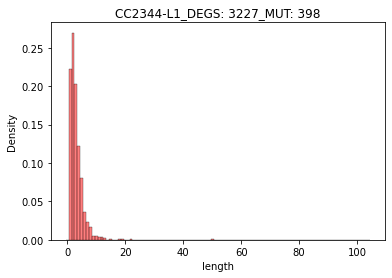

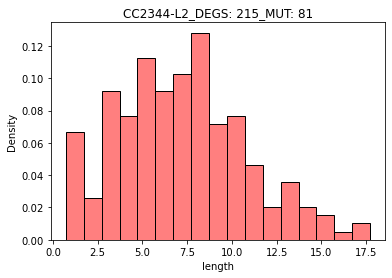

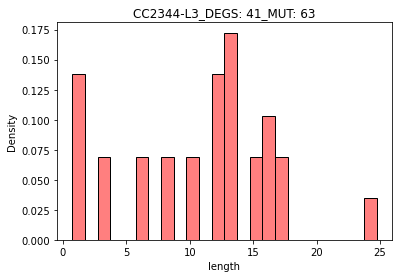

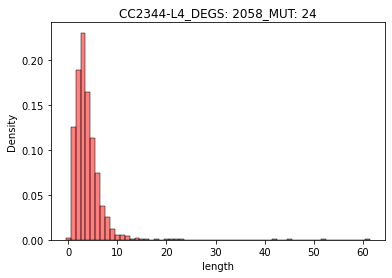

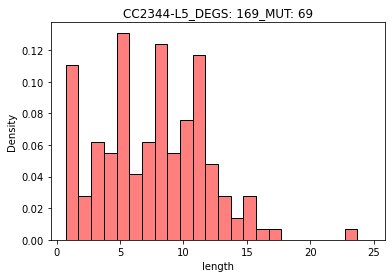

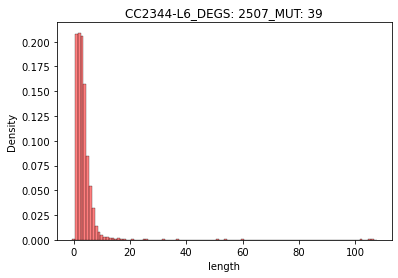

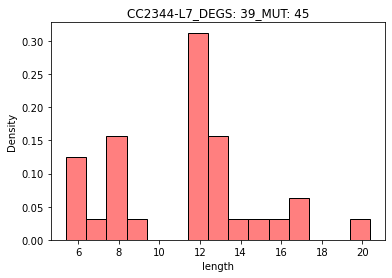

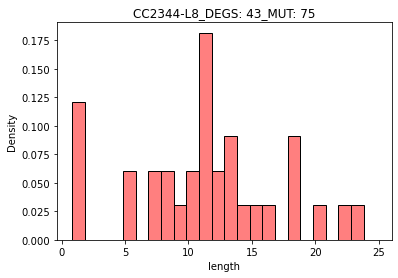

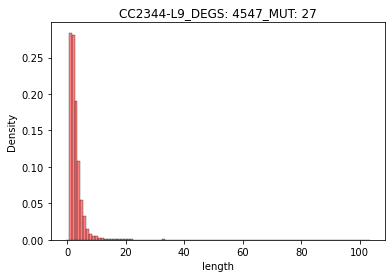

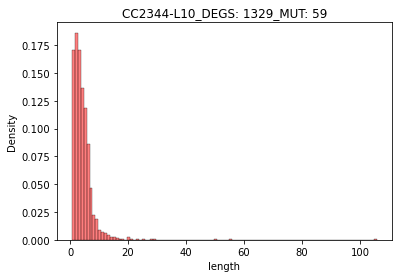

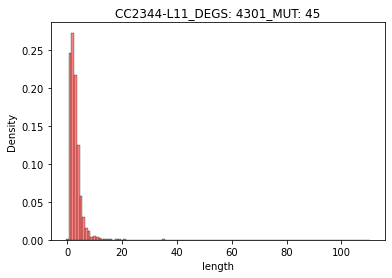

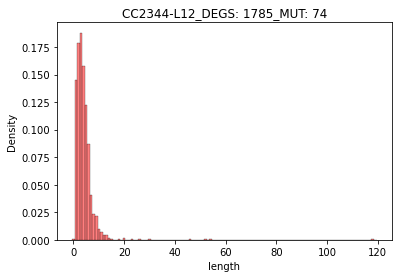

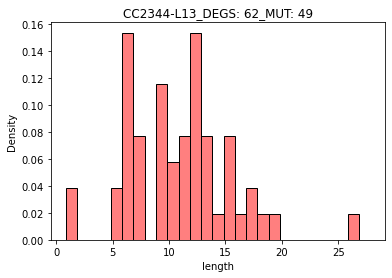

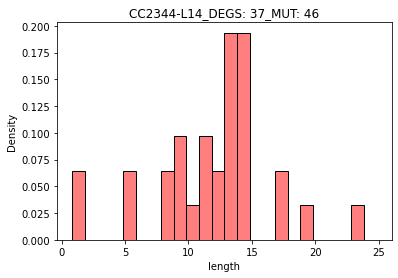

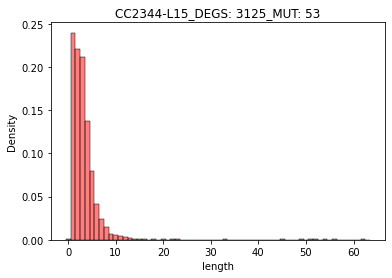

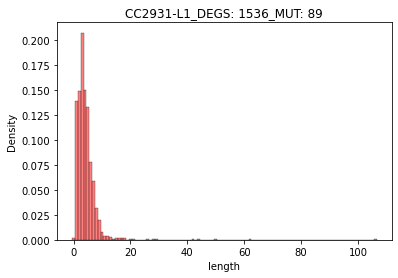

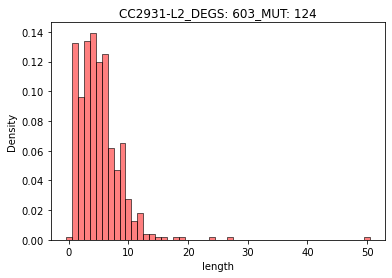

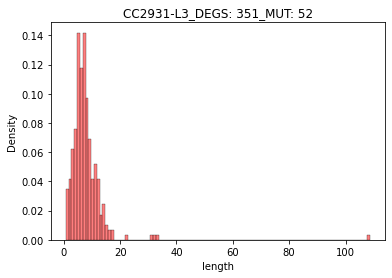

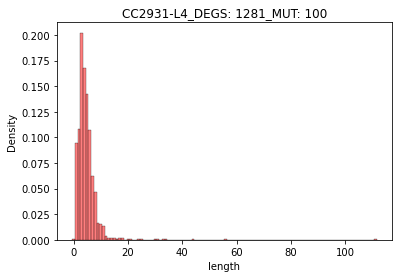

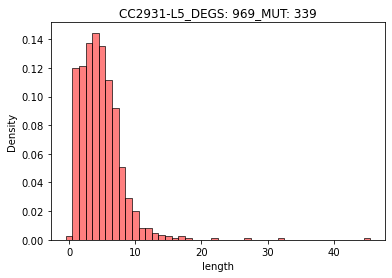

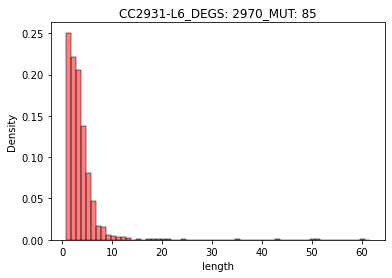

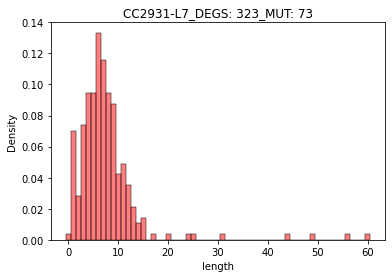

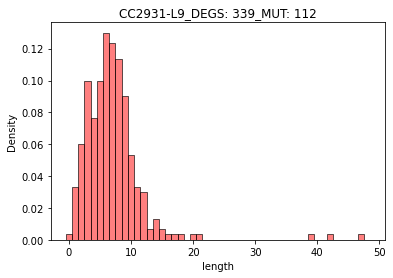

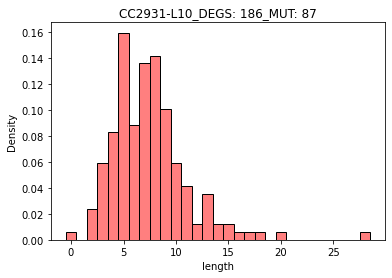

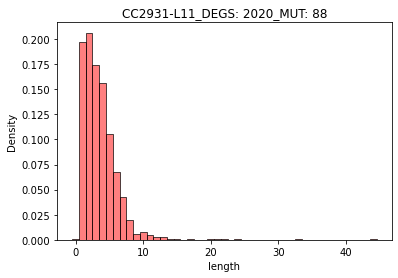

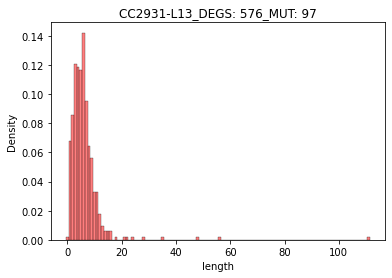

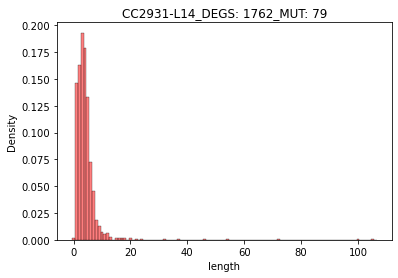

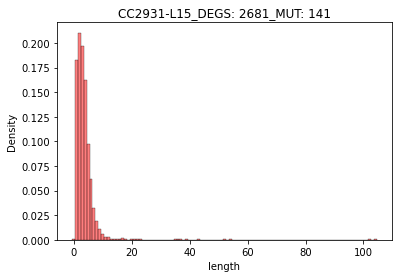

<Figure size 432x288 with 0 Axes>

In [3]:
type_gene = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/annotation/v6_genes.csv', delimiter = '\t')
version_conversion = pd.read_csv('/research/projects/chlamydomonas/MAexpression/genome_info/v5.3_to_v5.6_to_v6.csv', delimiter = '\t')
DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes1.csv', delimiter = ',').reset_index()
DEGs = pd.melt(DEGs, id_vars = ['index'], value_vars = CC2344 + CC2931).dropna()
DEGs.columns = ['index', 'sample', 'v6']
v5_DEGs = DEGs.set_index('v6').join(version_conversion.set_index('v6')[['v5.5_gene']]).drop(columns = ['index'])
  
for sample in CC2344 + CC2931:
    ## Opening shortest paths for observed samples ##
    sp = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/v5_DEGs/chlamynet_shortest_paths/' + sample + '.csv', delimiter = '\t')
    sns.histplot(data = sp['length'], stat="density", discrete = True, color = 'red', alpha = 0.5)
    plt.title(sample + '_DEGS: ' + str(len(DEGs.loc[DEGs['sample'] == sample])) + '_MUT: ' + str(len(mutations.loc[mutations['sample'] == sample])))
    plt.figure()

#### Observed vs Null Distributions

CC2344-L1_pvalue = 0.0
CC2344-L2_pvalue = 0.0
CC2344-L3_pvalue = 0.0
CC2344-L4_pvalue = 0.0
CC2344-L5_pvalue = 0.0
CC2344-L6_pvalue = 0.0
CC2344-L7_pvalue = 0.43
CC2344-L8_pvalue = 0.03
CC2344-L9_pvalue = 0.0
CC2344-L10_pvalue = 0.0


<ipython-input-3-6aaa8e63f71f>:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


CC2344-L11_pvalue = 0.0
CC2344-L12_pvalue = 0.0
CC2344-L13_pvalue = 0.45
CC2344-L14_pvalue = 0.13
CC2344-L15_pvalue = 0.0
CC2931-L1_pvalue = 0.0
CC2931-L2_pvalue = 0.0
CC2931-L3_pvalue = 0.64
CC2931-L4_pvalue = 0.0
CC2931-L5_pvalue = 0.0
CC2931-L6_pvalue = 0.0
CC2931-L7_pvalue = 0.02
CC2931-L9_pvalue = 0.02
CC2931-L10_pvalue = 0.0
CC2931-L11_pvalue = 0.0
CC2931-L13_pvalue = 0.0
CC2931-L14_pvalue = 0.0
CC2931-L15_pvalue = 0.0


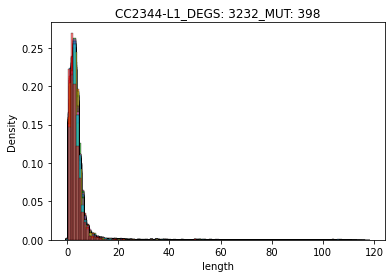

<Figure size 432x288 with 0 Axes>

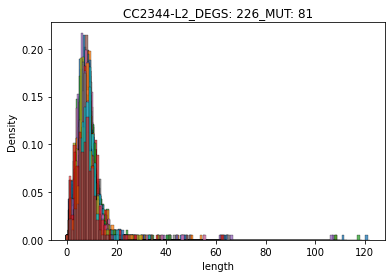

<Figure size 432x288 with 0 Axes>

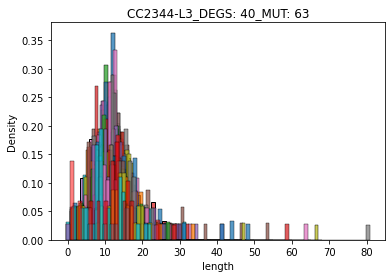

<Figure size 432x288 with 0 Axes>

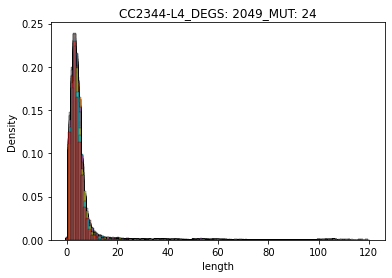

<Figure size 432x288 with 0 Axes>

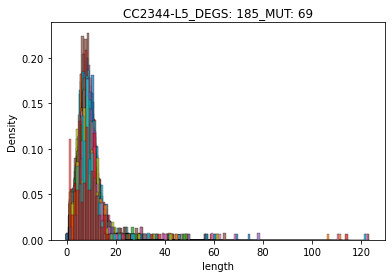

<Figure size 432x288 with 0 Axes>

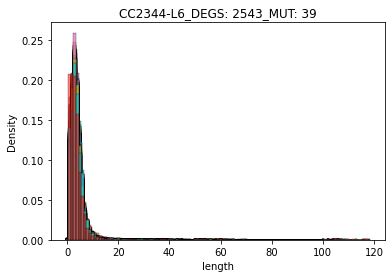

<Figure size 432x288 with 0 Axes>

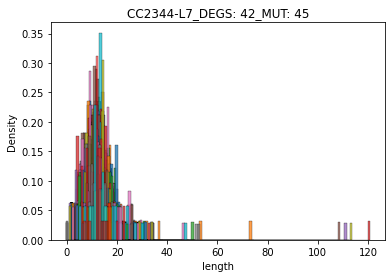

<Figure size 432x288 with 0 Axes>

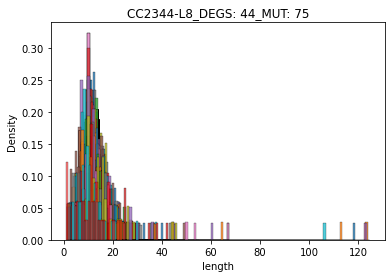

<Figure size 432x288 with 0 Axes>

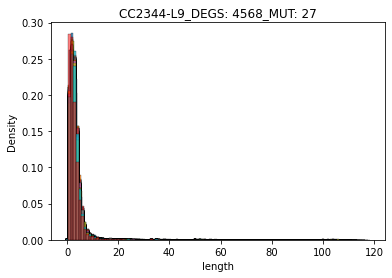

<Figure size 432x288 with 0 Axes>

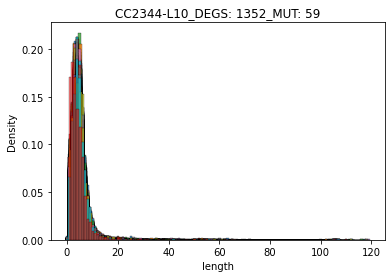

<Figure size 432x288 with 0 Axes>

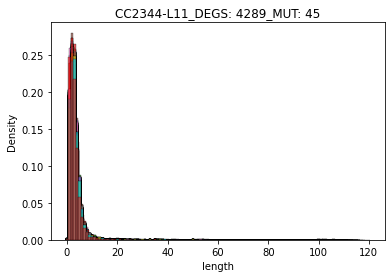

<Figure size 432x288 with 0 Axes>

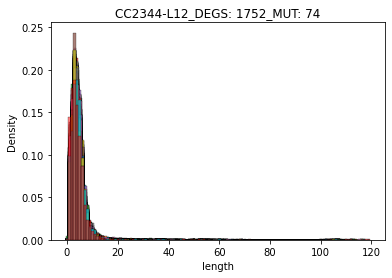

<Figure size 432x288 with 0 Axes>

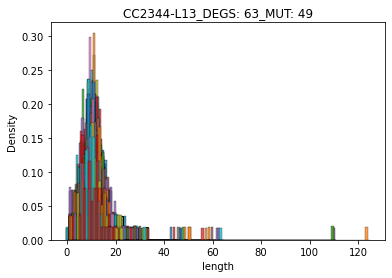

<Figure size 432x288 with 0 Axes>

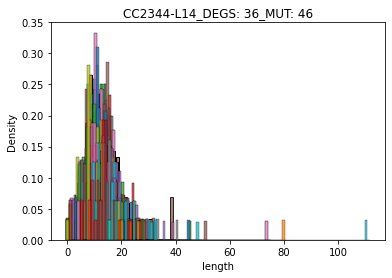

<Figure size 432x288 with 0 Axes>

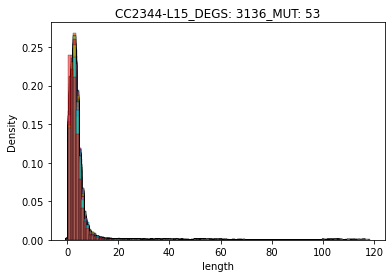

<Figure size 432x288 with 0 Axes>

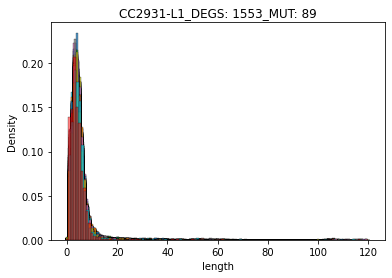

<Figure size 432x288 with 0 Axes>

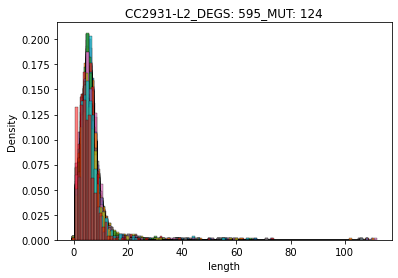

<Figure size 432x288 with 0 Axes>

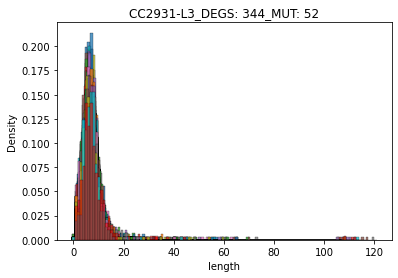

<Figure size 432x288 with 0 Axes>

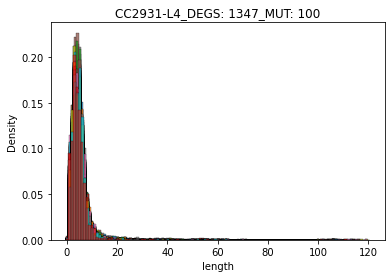

<Figure size 432x288 with 0 Axes>

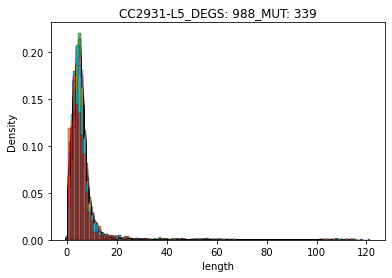

<Figure size 432x288 with 0 Axes>

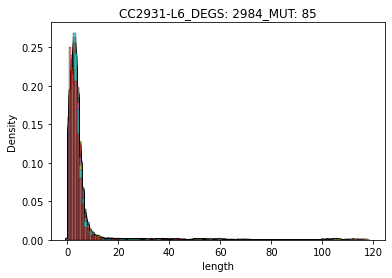

<Figure size 432x288 with 0 Axes>

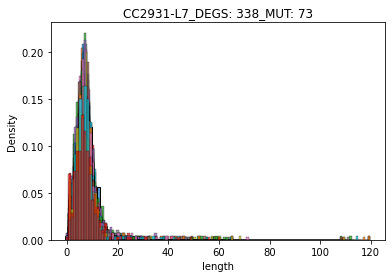

<Figure size 432x288 with 0 Axes>

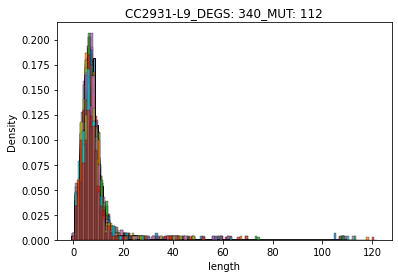

<Figure size 432x288 with 0 Axes>

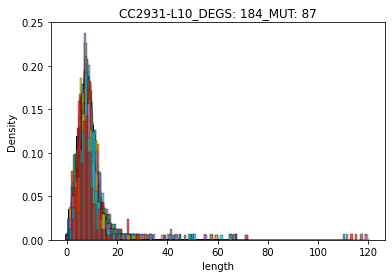

<Figure size 432x288 with 0 Axes>

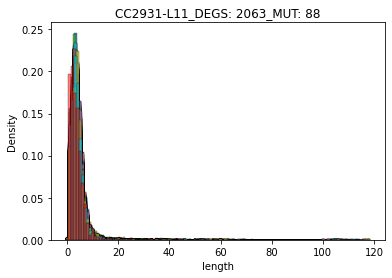

<Figure size 432x288 with 0 Axes>

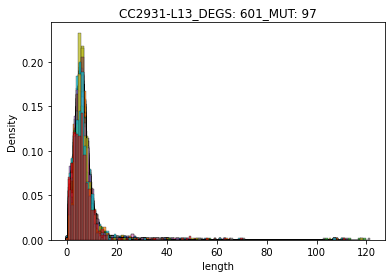

<Figure size 432x288 with 0 Axes>

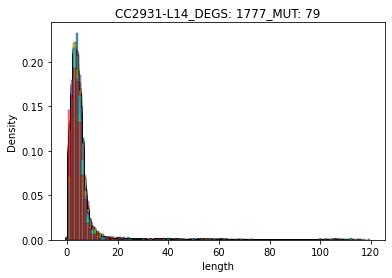

<Figure size 432x288 with 0 Axes>

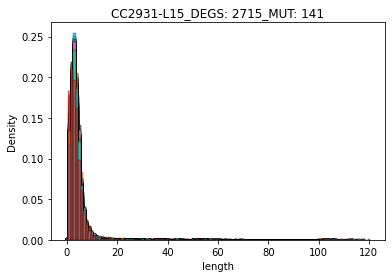

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [3]:
type_gene = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/annotation/v6_genes.csv', delimiter = '\t')
version_conversion = pd.read_csv('/research/projects/chlamydomonas/MAexpression/genome_info/v5.3_to_v5.6_to_v6.csv', delimiter = '\t')
DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes1.csv', delimiter = ',').reset_index()
DEGs = pd.melt(DEGs, id_vars = ['index'], value_vars = CC2344 + CC2931).dropna()
DEGs.columns = ['index', 'sample', 'v6']
v5_DEGs = DEGs.set_index('v6').join(version_conversion.set_index('v6')[['v5.5_gene']]).drop(columns = ['index'])
  
p_values = pd.DataFrame()

for sample in CC2344 + CC2931:
    pval = 0
    total_trials = 0
    ## Opening shortest paths for observed samples ##
    sp = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/v5_DEGs/chlamynet_shortest_paths/' + sample + '.csv', delimiter = '\t')

    ## Opening shorest paths for simulated samples ##
    path_to_directory = '/research/projects/chlamydomonas/MAexpression/analysis/DEGs/simulated_DEGs/chlamynet_shortest_paths/'
    bootstrap = 0
    for filename in glob.iglob(f'{path_to_directory}/bootstrap_*_' + sample + '.tsv'):
        bootstrap += 1
        sim_sp = pd.read_csv(filename, delimiter = '\t')
        if len(sim_sp) != 0:
            ## Adding plots of simulated samples ##
            sns.histplot(data = sim_sp['length'], stat="density", discrete = True)
            plt.title(sample + '_DEGS: ' + str(len(DEGs.loc[DEGs['sample'] == sample])) + '_MUT: ' + str(len(mutations.loc[mutations['sample'] == sample])))
            total_trials += 1
            ## p value ##
            if len(sim_sp.loc[(sim_sp['length'] > 0) & (sim_sp['length'] <= 5)]) > len(sp.loc[(sp['length'] > 0) & (sp['length'] <= 5)]): pval += 1
    ## Adding plots of observed samples ##
    if len(sp) != 0:
        sns.histplot(data = sp['length'], stat="density", discrete = True, color = 'red', alpha = 0.5)
        plt.title(sample + '_DEGS: ' + str(len(DEGs.loc[DEGs['sample'] == sample])) + '_MUT: ' + str(len(mutations.loc[mutations['sample'] == sample])))
        plt.figure()
    p_values.at[sample, 'p_value'] = pval/total_trials
    print(sample + '_pvalue = ' + str(pval/total_trials))
    plt.figure()
    
p_values.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/strenkert_coexpression_shortest_paths_pval.csv', sep = '\t', index = True, header = True)

#### Representative Plot (CC-2344 L1) - Observed vs Null Distributions

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

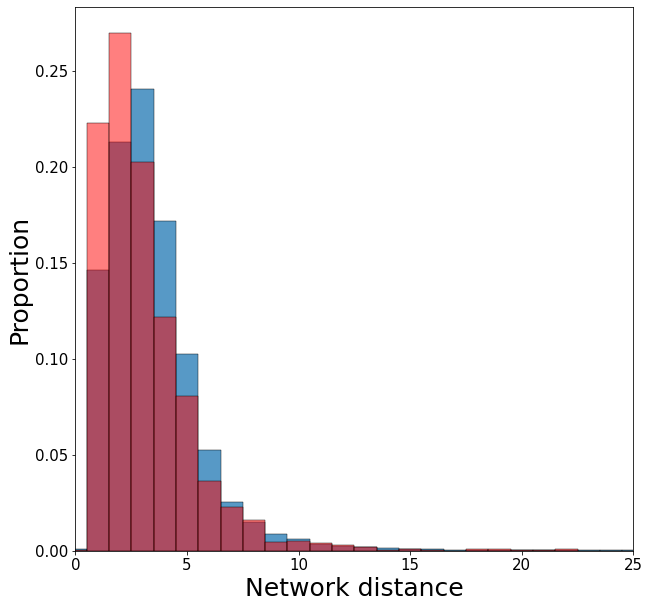

In [2]:
type_gene = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/annotation/v6_genes.csv', delimiter = '\t')
version_conversion = pd.read_csv('/research/projects/chlamydomonas/MAexpression/genome_info/v5.3_to_v5.6_to_v6.csv', delimiter = '\t')
DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes1.csv', delimiter = ',').reset_index()
DEGs = pd.melt(DEGs, id_vars = ['index'], value_vars = CC2344 + CC2931).dropna()
DEGs.columns = ['index', 'sample', 'v6']
v5_DEGs = DEGs.set_index('v6').join(version_conversion.set_index('v6')[['v5.5_gene']]).drop(columns = ['index'])
  
plt.figure(figsize = (10, 10))
for sample in ['CC2344-L1']:
    pval = 0
    ## Opening shortest paths for observed samples ##
    sp = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/v5_DEGs/chlamynet_shortest_paths/' + sample + '.csv', delimiter = '\t')

    ## Opening shorest paths for simulated samples ##
    path_to_directory = '/research/projects/chlamydomonas/MAexpression/analysis/DEGs/simulated_DEGs/chlamynet_shortest_paths/'
    bootstrap = 0
    total_sim_sp = pd.DataFrame()
    total_sim_length = []
    for filename in glob.iglob(f'{path_to_directory}/bootstrap_*_' + sample + '.tsv'):
        bootstrap += 1
        sim_sp = pd.read_csv(filename, delimiter = '\t')
        total_sim_length += sim_sp['length'].values.tolist()
    total_sim_sp['length'] = total_sim_length
    
    ## Adding plots of simulated samples ##
    sns.histplot(data = total_sim_sp['length'], stat="density", discrete = True)
    
    ## Adding plots of observed samples ##
    if len(sp) != 0:
        sns.histplot(data = sp['length'], stat="density", discrete = True, color = 'red', alpha = 0.5)
        plt.ylabel('Proportion', fontsize = 25)
        plt.xlabel('Network distance', fontsize = 25)
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.xlim(0, 25)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/CC2344-L1_observed_vs_simulated_distance_Strenkert_coexpression.pdf', format = 'pdf', dpi = 600, bbox_inches = 'tight')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/CC2344-L1_observed_vs_simulated_distance_Strenkert_coexpression.eps', format = 'eps', dpi = 600, bbox_inches = 'tight')

#### Permutations test - Shortest distance of observed vs simulated degs over varying distances

In [6]:
type_gene = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/annotation/v6_genes.csv', delimiter = '\t')
version_conversion = pd.read_csv('/research/projects/chlamydomonas/MAexpression/genome_info/v5.3_to_v5.6_to_v6.csv', delimiter = '\t')
DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes1.csv', delimiter = ',').reset_index()
DEGs = pd.melt(DEGs, id_vars = ['index'], value_vars = CC2344 + CC2931).dropna()
DEGs.columns = ['index', 'sample', 'v6']
v5_DEGs = DEGs.set_index('v6').join(version_conversion.set_index('v6')[['v5.5_gene']]).drop(columns = ['index'])

pval_dis = pd.DataFrame()
for distance in range(0, 20):
    for sample in CC2344 + CC2931:
        pval = 0
        total_trials = 0
        ## Opening shortest paths for observed samples ##
        sp = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/v5_DEGs/chlamynet_shortest_paths/' + sample + '.csv', delimiter = '\t')
        sp['length'] = sp['length'].replace(0, np.nan).dropna()
        
        ## Opening shorest paths for simulated samples ##
        path_to_directory = '/research/projects/chlamydomonas/MAexpression/analysis/DEGs/simulated_DEGs/chlamynet_shortest_paths/'
        bootstrap = 0
        for filename in glob.iglob(f'{path_to_directory}/bootstrap_*_' + sample + '.tsv'):
            bootstrap += 1
            sim_sp = pd.read_csv(filename, delimiter = '\t')
            if len(sim_sp) != 0:
                sim_sp['length'] = sim_sp['length'].replace(0, np.nan)
                sim_sp = sim_sp.dropna()
                if len(sim_sp) != 0:
                    total_trials += 1
                    ## p value ##
                    if len(sim_sp.loc[sim_sp['length'] <= distance + 1]) > len(sp.loc[sp['length'] <= distance + 1]): pval += 1
        pval_dis.at[sample, distance + 1] = pval/total_trials
    print('done')
pval_dis.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/shortest_distance_coexpression_network.csv', sep = '\t', index = True, header = True)

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
